# Train a miniGPT language model with JAX

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_for_LLM_pretraining.ipynb"><img src="https://www.kaggle.com/static/images/logos/kaggle-logo-transparent-300.png" height="32" width="70"/>Run in Kaggle</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_for_LLM_pretraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_for_LLM_pretraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This tutorial demonstrates how to use JAX, [Flax NNX](http://flax.readthedocs.io) and [Optax](http://optax.readthedocs.io) for language model (pre)training using data and tensor [parallelism](https://jax.readthedocs.io/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization) for [Single-Program Multi-Data](https://en.wikipedia.org/wiki/Single_program,_multiple_data)). It was originally inspired by the [Keras miniGPT tutorial](https://keras.io/examples/generative/text_generation_with_miniature_gpt/).

Here, you will learn how to:

- Define the miniGPT model with Flax and JAX automatic parallelism
- Load and preprocess the dataset
- Create the loss and training step functions
- Train the model on TPUs on Kaggle or Google Colab
- Profile for hyperparameter tuning

If you are new to JAX for AI, check out the [introductory tutorial](https://jax-ai-stack.readthedocs.io/en/latest/neural_net_basics.html), which covers neural network building with [Flax NNX](https://flax.readthedocs.io/en/latest/nnx_basics.html).

## Setup

JAX installation is covered in [this guide](https://jax.readthedocs.io/en/latest/installation.html) on the JAX documentation site. We will use [Tiktoken](https://github.com/openai/tiktoken) for tokenization and [Grain](https://google-grain.readthedocs.io/en/latest/index.html) for data loading.

In [ ]:
!pip install -Uq tiktoken jax-ai-stack[grain] matplotlib

**Note:** If you are using [Kaggle](https://www.kaggle.com/), select the free TPU v5e-8 as the hardware accelerator. If you are using [Google Colab](https://colab.research.google.com/), select the free Google Cloud TPU v5e-1 as the hardware accelerator. You may also use Google Cloud TPUs.

Check the available JAX devices, or [`jax.Device`](https://jax.readthedocs.io/en/latest/_autosummary/jax.Device.html), with [`jax.devices()`](https://jax.readthedocs.io/en/latest/_autosummary/jax.devices.html). The output of the cell below will show a list of 8 (eight) devices.

In [1]:
import jax
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]

Get the [TinyStories dataset from Hugging Face](https://huggingface.co/datasets/roneneldan/TinyStories). We only use the training split.

In [ ]:
!wget https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories-train.txt?download=true -O TinyStories-train.txt

Import the necessary modules, including JAX NumPy, Flax NNX, Optax, Grain, pandas, and Tiktoken:

In [2]:
import jax
import jax.numpy as jnp

from jax.sharding import Mesh, PartitionSpec as P, NamedSharding # For data and model parallelism (explained in more detail later)
from jax.experimental import mesh_utils

import flax.nnx as nnx
import optax

from dataclasses import dataclass
import grain.python as pygrain
import pandas as pd
import tiktoken
import time

## Define the miniGPT model with Flax and JAX automatic parallelism

### Leveraging JAX's data and tensor parallelism

One of the most powerful features of JAX is [device parallelism](https://jax.readthedocs.io/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization) for SPMD.

- The data parallelism technique enables, for example, the training data to run via multiple parts (this is called sharding) - batches - in parallel and simultaneously across different devices, such as GPUs and Google TPUs. This allows to use larger batch sizes to speed up training.
- Tensor parallelism allows us to split the model parameter tensors across several devices (sharding model tensors).
- You can learn more about the basics of JAX parallelism in more detail in the [Introduction to parallel programming](https://jax.readthedocs.io/en/latest/sharded-computation.html) on the JAX documentation site.

In this example, we'll utilize a 4-way data parallel and 2-way tensor parallel setup, which is aligned with Kaggle TPU v5e-8 or newer GCP TPUs chips.

Note that as of October 2025, free-tier Colab only offers TPU v5e-1, which can no longer support SPMD.

### jax.sharding.Mesh

Earlier, we imported [`jax.sharding.Mesh`](https://jax.readthedocs.io/en/latest/jax.sharding.html#jax.sharding.Mesh) - is a multidimensional NumPy array of JAX devices, where each axis of the mesh has a name, such as `'x'` or `'y'`. This will help encapsulate the information about the TPU resource organization for distributing computations across the devices.

Our `Mesh` will have two arguments:
- `devices`: This will take the value of [`jax.experimental.mesh_utils((4, 2))`](https://jax.readthedocs.io/en/latest/jax.experimental.mesh_utils.html), enabling us to build a device mesh. It is a NumPy ndarray with JAX devices (a list of devices from the JAX backend as obtained from [`jax.devices()`](https://jax.readthedocs.io/en/latest/_autosummary/jax.devices.html#jax.devices))..
- `axis_names`, where:
  - `batch`: 4 devices along the first axis - i.e. sharded into 4 - for data parallelism; and
  - `model`: 2 devices along the second axis - i.e. sharded into 2 -  for tensor parallism

This matches the structure in the Kaggle TPU v5e setup.

Let's instantiate `Mesh` as `mesh` and declare the TPU configuration to define how data and model parameters are distributed across the devices:

In [3]:
# Create a `Mesh` object representing TPU device arrangement.
# For example, for Kaggle TPU v5e-8:
if jax.device_count() == 8:
    mesh = Mesh(mesh_utils.create_device_mesh((4, 2)), ('batch', 'model'))

    ### Alternatively, we could use the 8-way data parallelism with only one line of code change.
    ### JAX enables quick experimentation with different partitioning strategies
    ### like this. We will come back to this point at the end of this tutorial.
    # mesh = Mesh(mesh_utils.create_device_mesh((8, 1)), ('batch', 'model'))

### For free-tier Colab TPU, which only has a single TPU core
if jax.device_count() == 1:
    mesh = Mesh(mesh_utils.create_device_mesh((1, 1)), ("batch", "model"))

We will use the GPT-2 tokenizer from the [Tiktoken](https://github.com/openai/tiktoken) library:

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")

To leverage model parallelism, we need to instruct the JAX compiler how to shard the model tensors across the TPU devices. Earlier, we also imported [`jax.sharding.PartitionSpec`](https://jax.readthedocs.io/en/latest/jax.sharding.html#jax.sharding.PartitionSpec) and [`jax.sharding.NamedSharding`](https://jax.readthedocs.io/en/latest/jax.sharding.html#jax.sharding.NamedSharding):
- [`PartitionSpec`](https://jax.readthedocs.io/en/latest/jax.sharding.html#jax.sharding.PartitionSpec) (using alias `P`) defines how tensors are sharded across the devices in our `Mesh`. Its elements describe how an input dimension is partitioned across mesh dimensions. For example, in `PartitionSpec('x', 'y')` the first dimension of data is sharded across `x` axis of the mesh, and the second one - across the `y` axis.
  - We'll use `PartitionSpec` to describe how to shard a tensor across, for example, the `model` axis or be replicated on other dimensions (which is denoted by `None`).
- [`NamedSharding`](https://jax.readthedocs.io/en/latest/jax.sharding.html#jax.sharding.NamedSharding) is a (`Mesh`, `PartitionSpec`) pair that describes how to shard a model tensor across our `mesh`.
- We combine `Mesh` (the TPU resources) with `PartitionSpec` and create a `NamedSharding`, which instructs how to shard each model tensor across the TPU devices.

Additionally, we'll use Flax NNX's [`flax.nnx.with_partitioning`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/spmd.html#flax.nnx.with_partitioning) to let each model layer know that the model weights or tensors need to be sharded according to our specification. We need to do this for every tensor/layer in the model.
- `nnx.with_partitioning` will take two arguments, such as the `initializer` (such as [`flax.nnx.initializers.xavier_uniform`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/nn/initializers.html#flax.nnx.initializers.xavier_uniform) and [`flax.nnx.initializers.zeros_init`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/nn/initializers.html#flax.nnx.initializers.zeros_init)) and `sharding` (e.g. `NamedSharding(Mesh, PartitionSpec)` or `NamedSharding(mesh, P('model')` in our case).

In [5]:
# Define a triangular mask for causal attention with `jax.numpy.tril` and `jax.numpy.ones`.
def causal_attention_mask(seq_len):
    return jnp.tril(jnp.ones((seq_len, seq_len)))

class TransformerBlock(nnx.Module):
    """ A single Transformer block.

    Each Transformer block processes input sequences via self-attention and feed-forward networks.

    Args:
        embed_dim (int): Embedding dimensionality.
        num_heads (int): Number of attention heads.
        ff_dim (int): Dimensionality of the feed-forward network.
        rngs (flax.nnx.Rngs): A Flax NNX stream of JAX PRNG keys.
        rate (float): Dropout rate. Defaults to 0.1.
    """
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, *, rngs: nnx.Rngs, rate: float = 0.1):
        # Multi-Head Attention (MHA) with `flax.nnx.MultiHeadAttention`.
        # Specifies tensor sharding (depending on the mesh configuration)
        # where we shard the weights across devices for parallel computation.
        self.mha = nnx.MultiHeadAttention(num_heads=num_heads,
                                          in_features=embed_dim,
                                          kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), P(None, 'model')),
                                          bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), P('model')),
                                          rngs=rngs)
        # The first dropout with `flax.nnx.Dropout`.
        self.dropout1 = nnx.Dropout(rate=rate)
        # First layer normalization with `flax.nnx.LayerNorm`.
        self.layer_norm1 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), P('model')),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), P('model')),
                                         rngs=rngs)
        # The first linear transformation for the feed-forward network with `flax.nnx.Linear`.
        self.linear1 = nnx.Linear(in_features=embed_dim,
                                  out_features=ff_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), P(None, 'model')),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), P('model')),
                                  rngs=rngs)
        # The second linear transformation for the feed-forward network with `flax.nnx.Linear`.
        self.linear2 = nnx.Linear(in_features=ff_dim,
                                  out_features=embed_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), P(None, 'model')),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), P('model')),
                                  rngs=rngs)
        # The second dropout with `flax.nnx.Dropout`.
        self.dropout2 = nnx.Dropout(rate=rate)
        # Second layer normalization with `flax.nnx.LayerNorm`.
        self.layer_norm2 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), P('model')),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), P('model')),
                                         rngs=rngs)

    # Apply the Transformer block to the input sequence.
    def __call__(self, inputs, training: bool = False):
        input_shape = inputs.shape
        _, seq_len, _ = input_shape

        # Instantiate the causal attention mask.
        mask = causal_attention_mask(seq_len)

        # Apply Multi-Head Attention with the causal attention mask.
        attention_output = self.mha(
            inputs_q=inputs,
            mask=mask,
            decode=False
        )
        # Apply the first dropout.
        attention_output = self.dropout1(attention_output, deterministic=not training)
        # Apply the first layer normalization.
        out1 = self.layer_norm1(inputs + attention_output)

        # The feed-forward network.
        # Apply the first linear transformation.
        ffn_output = self.linear1(out1)
        # Apply the ReLU activation with `flax.nnx.relu`.
        ffn_output = nnx.relu(ffn_output)
        # Apply the second linear transformation.
        ffn_output = self.linear2(ffn_output)
        # Apply the second dropout.
        ffn_output = self.dropout2(ffn_output, deterministic=not training)
        # Apply the second layer normalization and return the output of the Transformer block.
        return self.layer_norm2(out1 + ffn_output)

class TokenAndPositionEmbedding(nnx.Module):
    """ Combines token embeddings (words in an input sentence) with
    positional embeddings (the position of each word in a sentence).

    Args:
        maxlen (int): Matimum sequence length.
        vocal_size (int): Vocabulary size.
        embed_dim (int): Embedding dimensionality.
        rngs (flax.nnx.Rngs): A Flax NNX stream of JAX PRNG keys.
    """
    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, *, rngs: nnx.Rngs):
        # Initialize token embeddings (using `flax.nnx.Embed`).
        # Each unique word has an embedding vector.
        self.token_emb = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, rngs=rngs)
        # Initialize positional embeddings (using `flax.nnx.Embed`).
        self.pos_emb = nnx.Embed(num_embeddings=maxlen, features=embed_dim, rngs=rngs)

    # Takes a token sequence (integers) and returns the combined token and positional embeddings.
    def __call__(self, x):
        # Generate a sequence of positions for the input tokens.
        positions = jnp.arange(0, x.shape[1])[None, :]
        # Look up the positional embeddings for each position in the input sequence.
        position_embedding = self.pos_emb(positions)
        # Look up the token embeddings for each token in the input sequence.
        token_embedding = self.token_emb(x)
        # Combine token and positional embeddings.
        return token_embedding + position_embedding

class MiniGPT(nnx.Module, pytree=False):
    """ A miniGPT transformer model, inherits from `flax.nnx.Module`.

    Args:
        maxlen (int): Maximum sequence length.
        vocab_size (int): Vocabulary size.
        embed_dim (int): Embedding dimensionality.
        num_heads (int): Number of attention heads.
        feed_forward_dim (int): Dimensionality of the feed-forward network.
        num_transformer_blocks (int): Number of transformer blocks. Each block contains attention and feed-forward networks.
        rngs (nnx.Rngs): A Flax NNX stream of JAX PRNG keys.
    """
    # Initialize miniGPT model components.
    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, num_heads: int, feed_forward_dim: int, num_transformer_blocks: int, rngs: nnx.Rngs):
        # Initiliaze the `TokenAndPositionEmbedding` that combines token and positional embeddings.
        print("Initializing")
        self.embedding_layer = TokenAndPositionEmbedding(
                    maxlen, vocab_size, embed_dim, rngs=rngs
                )
        # Create a list of `TransformerBlock` instances.
        # Each block processes input sequences using attention and feed-forward networks.
        print("Transformer block")
        self.transformer_blocks = [TransformerBlock(
            embed_dim, num_heads, feed_forward_dim, rngs=rngs
        ) for _ in range(num_transformer_blocks)]
        # Initialize the output `flax.nnx.Linear` layer producing logits over the vocabulary for next-token prediction.
        print("Output layer")
        self.output_layer = nnx.Linear(in_features=embed_dim,
                                       out_features=vocab_size,
                                       kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), P('model')),
                                       bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), P('model')),
                                       rngs=rngs)
        print("Done")

    def __call__(self, inputs, training: bool = False):
        # Pass the input tokens through the `embedding_layer` to get token embeddings.
        # Apply each transformer block sequentially to the embedded input, use the `training` flag for the behavior of `flax.nnx.Dropout`.
        x = self.embedding_layer(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        # Pass the output of the transformer blocks through the output layer,
        # and obtain logits for each token in the vocabulary (for next token prediction).
        outputs = self.output_layer(x)
        return outputs

    @nnx.jit
    def sample_from(self, logits):
        logits, indices = jax.lax.top_k(logits, k=top_k)
        logits = nnx.softmax(logits)
        return jax.random.choice(jax.random.PRNGKey(0), indices, p=logits)

    @nnx.jit
    def generate_step(self, padded_tokens, sample_index):
        logits = self(padded_tokens)
        next_token = self.sample_from(logits[0][sample_index])
        return next_token

    def generate_text(self, max_tokens, start_tokens):
        generated = []
        print(tokenizer.decode(start_tokens), flush=True, end='')
        for i in range(max_tokens):
            sample_index = len(start_tokens) + len(generated) - 1

            padded_tokens = jnp.array((start_tokens + generated + [0] * (maxlen - len(start_tokens) - len(generated))))[None, :]
            next_token = int(self.generate_step(padded_tokens, sample_index))
            if next_token == tokenizer.encode('<|endoftext|>', allowed_special={'<|endoftext|>'})[0]:
              break
            generated.append(next_token)
            # decode and print next_token
            print(tokenizer.decode([next_token]), flush=True, end='')
        return tokenizer.decode(start_tokens + generated)

# Creates the miniGPT model with 4 transformer blocks.
def create_model(rngs):
    return MiniGPT(maxlen, vocab_size, embed_dim, num_heads, feed_forward_dim, num_transformer_blocks=4, rngs=rngs)

In [7]:
tokenizer.n_vocab

50257

In [8]:
vocab_size = tokenizer.n_vocab
num_transformer_blocks = 8
maxlen = 256
embed_dim = 256
num_heads = 8
feed_forward_dim = 256
batch_size = 144 * jax.device_count() / 2  # divide by 2 in case of model parallelism
if jax.device_count() == 1:
    batch_size = 144
num_epochs = 1
top_k = 10

Set some hyperparameters.

## Loading and preprocessing the data

Data loading and preprocessing with [Grain](https://github.com/google/grain).

In [10]:
@dataclass
class TextDataset:
    data: list
    maxlen: int

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        # Use Tiktoken for tokenization
        encoding = tokenizer.encode(self.data[idx], allowed_special={'<|endoftext|>'})[:self.maxlen]  # Tokenize and truncate
        return encoding + [0] * (self.maxlen - len(encoding))  # Pad to maxlen

def load_and_preprocess_data(file_path, batch_size, maxlen):

    with open(file_path, 'r') as f:
      text = f.read()

    stories = text.split('<|endoftext|>')
    stories = [story+'<|endoftext|>' for story in stories if story.strip()]
    df = pd.DataFrame({'text': stories})
    data = df['text'].dropna().tolist()
    dataset = TextDataset(data, maxlen)

    sampler = pygrain.IndexSampler(
        len(dataset),
        shuffle=False,
        seed=42,
        shard_options=pygrain.NoSharding(),
        num_epochs=num_epochs,
    )

    dl = pygrain.DataLoader(
        data_source=dataset,
        sampler=sampler,
        operations=[pygrain.Batch(batch_size=batch_size, drop_remainder=True)],
    )

    return dl

text_dl = load_and_preprocess_data('TinyStories-train.txt', batch_size, maxlen)

## Defining the loss function and training step function

In [11]:
# Defines the loss function using `optax.softmax_cross_entropy_with_integer_labels`.
def loss_fn(model, batch):
    logits = model(batch[0])
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch[1]).mean()
    return loss, logits

# Define the training step with the `flax.nnx.jit` transformation decorator.
@nnx.jit
def train_step(model: MiniGPT, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, lables=batch[1])
    optimizer.update(model, grads)

## Training the model

Start training. It takes ~50 minutes on Colab.

Note that for data parallel, we are sharding the training data along the `batch` axis using `jax.device_put` with `NamedSharding`.

We are also using the `jax.vmap` transformation to produce the target sequences faster.

In [12]:
jax.set_mesh(mesh)
model = create_model(rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3), wrt=nnx.Param)
metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average("loss"),
)
rng = jax.random.PRNGKey(0)

start_prompt = "Once upon a time"
start_tokens = tokenizer.encode(start_prompt)[:maxlen]
print("Initial generated text:")
generated_text = model.generate_text(maxlen, start_tokens)

metrics_history = {
    "train_loss": [],
}

prep_target_batch = jax.vmap(
    lambda tokens: jnp.concatenate((tokens[1:], jnp.array([0])))
)

step = 0
for epoch in range(num_epochs):
    start_time = time.time()
    for batch in text_dl:
        if len(batch) % len(jax.devices()) != 0:
            continue  # skip the remaining elements
        input_batch = jnp.array(jnp.array(batch).T)
        target_batch = prep_target_batch(input_batch)
        train_step(
            model,
            optimizer,
            metrics,
            jax.device_put(
                (input_batch, target_batch), NamedSharding(mesh, P("batch", None))
            ),
        )

        if (step + 1) % 200 == 0:
            for metric, value in metrics.compute().items():
                metrics_history[f"train_{metric}"].append(value)
            metrics.reset()

            elapsed_time = time.time() - start_time
            print(
                f"\n\nStep {step + 1}, Loss: {metrics_history['train_loss'][-1]}, Elapsed Time: {elapsed_time:.2f} seconds"
            )
            start_time = time.time()

            print("Generated text:")
            generated_text = model.generate_text(maxlen, start_tokens)

        step += 1

# Final text generation
print("Final generated text:")
generated_text = model.generate_text(maxlen, start_tokens)

Initializing
Transformer block
Output layer
Done
Initial generated text:
Once upon a timeaciaGender gearuser Analysisval {} Bruce Lauren helic Lauren Bruce againstliterally SQU retire Path {}valascript northwest {} Bruceuit Pathascript northwestdrops freelyvic996 curated hysteria FS psychedelic {}ligaval {} perished {} Woman {} {} inflicwaves Analysis996 servants Bruce Charlotte dissatisfiedascript Whites retire {} retire {} perished Schools {}Nick sorrow psychedelicfingerelaide {} perished Blackburnrestyy elder swing interesting Tang Shattered {} {}scl less abnorm abnorm Goldmancre motions fleshthird fatal haw {} perished {} Dani Whites {} Whites retire {} sorrowolate Whites {} Womanlast doom appendixfinger {}Rain pressurefinger {} {} Womanorem Bruce simplyrest {} {} inexplicablerest HS Charlotte dissatisfied stranger perished Tang reassUV {} Abortion outragedaligned {} server fertility decision FSShould {} {} northwestroid variable {} Whites {} dancersithmetic {} {} Whites las hamper

Visualize the training loss.

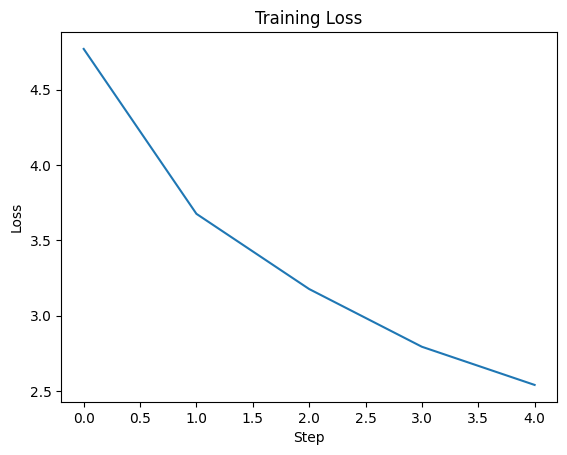

In [13]:
import matplotlib.pyplot as plt
plt.plot(metrics_history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

As you can see, the model goes from generating completely random words at the beginning to generating sensible tiny stories at the end of the training. So essentially we have pretrained a small LLM to write tiny stories for us.

In [14]:
# 파라미터 상태(State) 가져오기
state = nnx.state(model)

# 전체 파라미터(Leaf 노드들)의 크기 합산
total_params = sum(x.size for x in jax.tree_util.tree_leaves(state))
print(f"Total Parameters: {total_params:,}")

Total Parameters: 27,430,481


In [15]:
state = nnx.state(model)
flat_params = state.flat_state()
total_params = 0
# items()로 키(경로)와 값(파라미터 텐서)을 순회
for path_tuple, param in flat_params:
    # 1. 경로 튜플을 문자열로 변환 (예: ('linear1', 'kernel') -> 'linear1.kernel')
    path_str = ".".join(str(p) for p in path_tuple)
    
    # 2. 파라미터 형상(Shape)과 원소 개수(Size) 추출
    # param은 nnx.Variable 또는 jax.Array 형태일 수 있으므로 .value로 실제 값에 접근하거나 직접 속성 사용
    tensor = param.value if hasattr(param, 'value') else param
    shape = tensor.shape
    count = tensor.size
    
    # 3. 누적 합계 계산
    total_params += count
    
    # 4. 출력
    print(f"{path_str:<60} | {str(shape):<20} | {count:<15,}")

print("-" * 100)
print(f"Total Parameters: {total_params:,}")

embedding_layer.pos_emb.embedding                            | (256, 256)           | 65,536         
embedding_layer.token_emb.embedding                          | (50257, 256)         | 12,865,792     
output_layer.bias                                            | (50257,)             | 50,257         
output_layer.kernel                                          | (256, 50257)         | 12,865,792     
transformer_blocks.0.layer_norm1.bias                        | (256,)               | 256            
transformer_blocks.0.layer_norm1.scale                       | (256,)               | 256            
transformer_blocks.0.layer_norm2.bias                        | (256,)               | 256            
transformer_blocks.0.layer_norm2.scale                       | (256,)               | 256            
transformer_blocks.0.linear1.bias                            | (256,)               | 256            
transformer_blocks.0.linear1.kernel                          | (256, 256)         

## Saving the checkpoint

Save the model checkpoint.

In [ ]:
import orbax.checkpoint as orbax

dir = "/home/ext_jeehyeok_google_com/save"
state = nnx.state(model)

checkpointer = orbax.PyTreeCheckpointer()
checkpointer.save(dir, args=orbax.args.PyTreeSave(state), force=True)

# Make sure the files are there
!ls {dir}

## Embedding model

In [16]:
import jax
import jax.numpy as jnp
from flax import nnx

# 기존 TransformerBlock, TokenAndPositionEmbedding, causal_attention_mask는 그대로 사용합니다.
# (위에 정의된 코드를 재사용한다고 가정)

class MiniGPTEmbedding(nnx.Module, pytree=False):
    """
    MiniGPT based Text Embedding Model.
    Generates a fixed-size vector representation for input text.
    """
    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, num_heads: int, 
                 feed_forward_dim: int, num_transformer_blocks: int, rngs: nnx.Rngs):
        
        # 1. 임베딩 레이어 (동일)
        self.embedding_layer = TokenAndPositionEmbedding(
            maxlen, vocab_size, embed_dim, rngs=rngs
        )
        
        # 2. 트랜스포머 블록 스택 (동일)
        self.transformer_blocks = [TransformerBlock(
            embed_dim, num_heads, feed_forward_dim, rngs=rngs
        ) for _ in range(num_transformer_blocks)]
        
        # [변경점 1] Output Layer(Linear to vocab_size)를 제거했습니다.
        # 대신 임베딩 차원을 유지하거나, 특정 차원으로 줄이는 Projection Layer를 둘 수도 있습니다.
        # 여기서는 Raw Hidden State를 그대로 사용합니다.

    def __call__(self, inputs, training: bool = False):
        # 1. Embed inputs
        x = self.embedding_layer(inputs)
        
        # 2. Pass through Transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
            
        # x shape: (batch_size, seq_len, embed_dim)
        # [변경점 2] Logits을 반환하지 않고, 마지막 Hidden State 전체를 반환합니다.
        return x

    @nnx.jit
    def encode(self, inputs, attention_mask=None):
        """
        입력 텍스트를 하나의 벡터로 변환(Pooling)하여 반환합니다.
        여기서는 가장 널리 쓰이는 'Mean Pooling'을 구현합니다.
        """
        # (Batch, Seq, Dim) 형태의 Hidden State 획득
        hidden_states = self(inputs, training=False)
        
        # Mask가 없으면 패딩(0)이 아닌 부분만 1로 간주
        if attention_mask is None:
            attention_mask = (inputs != 0).astype(jnp.float32)
            
        # 차원 확장: (Batch, Seq) -> (Batch, Seq, 1)
        mask_expanded = attention_mask[:, :, None]
        
        # --- Mean Pooling 전략 ---
        # 패딩이 아닌 토큰들의 벡터만 합산
        sum_embeddings = jnp.sum(hidden_states * mask_expanded, axis=1)
        # 패딩이 아닌 토큰의 개수 합산 (0으로 나누기 방지용 clamp)
        sum_mask = jnp.clip(mask_expanded.sum(axis=1), a_min=1e-9)
        
        # 평균 계산
        sentence_embedding = sum_embeddings / sum_mask
        
        # (Optional) L2 정규화: 코사인 유사도 계산을 쉽게 하기 위함
        norm = jnp.linalg.norm(sentence_embedding, axis=1, keepdims=True)
        return sentence_embedding / norm

In [17]:
rngs = nnx.Rngs(42)
embedding_model = MiniGPTEmbedding(maxlen, vocab_size, embed_dim, num_heads, feed_forward_dim, num_transformer_blocks, rngs)

# 3. 더미 데이터 (Batch size = 2, 문장 길이 = 32)
sentence1 = tokenizer.encode("Today is Christmas")
sentence2 = tokenizer.encode("25 DEC is here")
input_ids = jnp.array([
    sentence1 + [0] * (maxlen - len(sentence1)),
    sentence2 + [0] * (maxlen - len(sentence2))
])

# 4. 임베딩 벡터 추출 (Encode)
embeddings = embedding_model.encode(input_ids)

print(f"Embedding Shape: {embeddings.shape}") 
# 출력: (2, 256) -> (배치 크기, 임베딩 차원)

# 5. 코사인 유사도 계산 (벡터 내적)
# 정규화가 되어 있으므로 내적(dot product)이 곧 코사인 유사도입니다.
vec_a = embeddings[0]
vec_b = embeddings[1]
similarity = jnp.dot(vec_a, vec_b)

print(f"Similarity: {similarity:.4f}")

Embedding Shape: (2, 256)
Similarity: 0.7332


## Profiling for hyperparameter tuning

**Note:** this section assume multiple TPU cores. Free-tier Colab TPU v5e-1 cannot run here.

In [ ]:
!pip install -Uq tensorboard-plugin-profile tensorflow tensorboard

Load the tensorboard colab extension.

In [ ]:
%load_ext tensorboard

As we're going to be running this model a number of times, we need some scaffolding to more easily compare our work. For a baseline, we'll need to perform some warmup to guarantee that our code is JIT'd and that our TPUs are warm. For improved comparability, we'll only start tracing after we've finished warmup.

In [ ]:
trace_dir = "/tmp/jax-trace/"

def loop_step(batch, step):
    input_batch = jnp.array(jnp.array(batch).T)
    target_batch = prep_target_batch(input_batch)
    train_step(model, optimizer, metrics, jax.device_put((input_batch, target_batch), NamedSharding(mesh, P('batch', None))))

def generate_trace():
    tracing_steps = 30
    warmup_steps = 5
    for current_step in range(warmup_steps + tracing_steps):
        if current_step == warmup_steps:
            jax.profiler.start_trace(trace_dir)
        with jax.profiler.StepTraceAnnotation("train", step_num=current_step):
            batch = next(text_dl)
            loop_step(batch, current_step)

    jax.profiler.stop_trace()

Now we'll perform some traces to compare results of different batch sizes. This will take several minutes as we need to reprocess our input data to prepare new batches each time.

In [ ]:
trace_dir = "/tmp/jax-trace-batch-comparison/"

batch_size = 64
text_dl = iter(load_and_preprocess_data('TinyStories-train.txt', batch_size, maxlen))
generate_trace()

batch_size = 256
text_dl = iter(load_and_preprocess_data('TinyStories-train.txt', batch_size, maxlen))
generate_trace()

Run Tensorboard with the Profiler Plugin to compare our runs. Runs are listed in order from newest to oldest, so the top run in the list will be have `batch_size = 256`.

The key metrics to focus on here for this hyperparameter are FLOPS Utilization and Average Step Time.

In general, we want to maximize FLOPS Utilization while minimizing the step time per training example. In this case, we can see that increasing the batch size from 64 -> 256 achieves both of those. FLOPS increases from 16% to 27%. Average Step Time increase from 100ms to 260ms, however we increased our batch size by 300%. This means we move from 1.5ms per training example to 1.02ms per training example.

In [ ]:
%tensorboard --logdir=$trace_dir

Next, we can explore alternative parallelism methods. In cell #4, we used 4-way data parallel and 2-way tensor parallel. 8-way data parallel is another popular way. Let's compare results between them. To switch to 8-way data parallel, we'll replace the `Mesh` definition with:

`mesh = Mesh(mesh_utils.create_device_mesh((8, 1)), ('batch', 'model'))`

JAX will automatically figure out how to shard the model and data to use the new partition strategy and nothing else need to be done. Re-connect the TPU runtime and run it again to see how it runs.

How simple and powerful is this! And that's the beauty of JAX automatic parallelism.

In [ ]:
trace_dir = "/tmp/jax-trace-parallelism-comparison/"

mesh = Mesh(mesh_utils.create_device_mesh((4, 2)), ('batch', 'model'))
generate_trace()

mesh = Mesh(mesh_utils.create_device_mesh((8, 1)), ('batch', 'model'))
generate_trace()

Once again we'll run tensorboard.

Looking at the results, we see that the step times are nearly the same, however the FLOPS Utilization is at 13% for 8-way data parallelism compared to 27% or 4-way data parallelism.

By looking at the Trace Viewer tool and looking under each TPU's ops, we can see that the TPUs spend a large amount of time idle while waiting for the host, as well as spending a good amount of time in `reduce_sum` operations.

In [ ]:
%tensorboard --logdir=$trace_dir

By changing hyperparameters and comparing profiles, we're able to gain significant insights into our bottlenecks and limitations. These are just two examples of hyperparameters to tune, but plenty more of them will have significant effects on training speed and resource utilization.